In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

# models
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow import keras
from keras import layers, Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Exploring Data

In [2]:
# reading data
#trainData = pd.read_csv("dataset/train.csv")
#testData = pd.read_csv("dataset/test.csv")
client = MongoClient('localhost', 27017)
db = client['digit-recognition']
collection = db['train']
trainData = pd.DataFrame(list(collection.find()))
collection = db['test']
testData = pd.DataFrame(list(collection.find()))

In [3]:
# separating images and labels
images, labels = trainData.iloc[:, 1:], trainData['label']

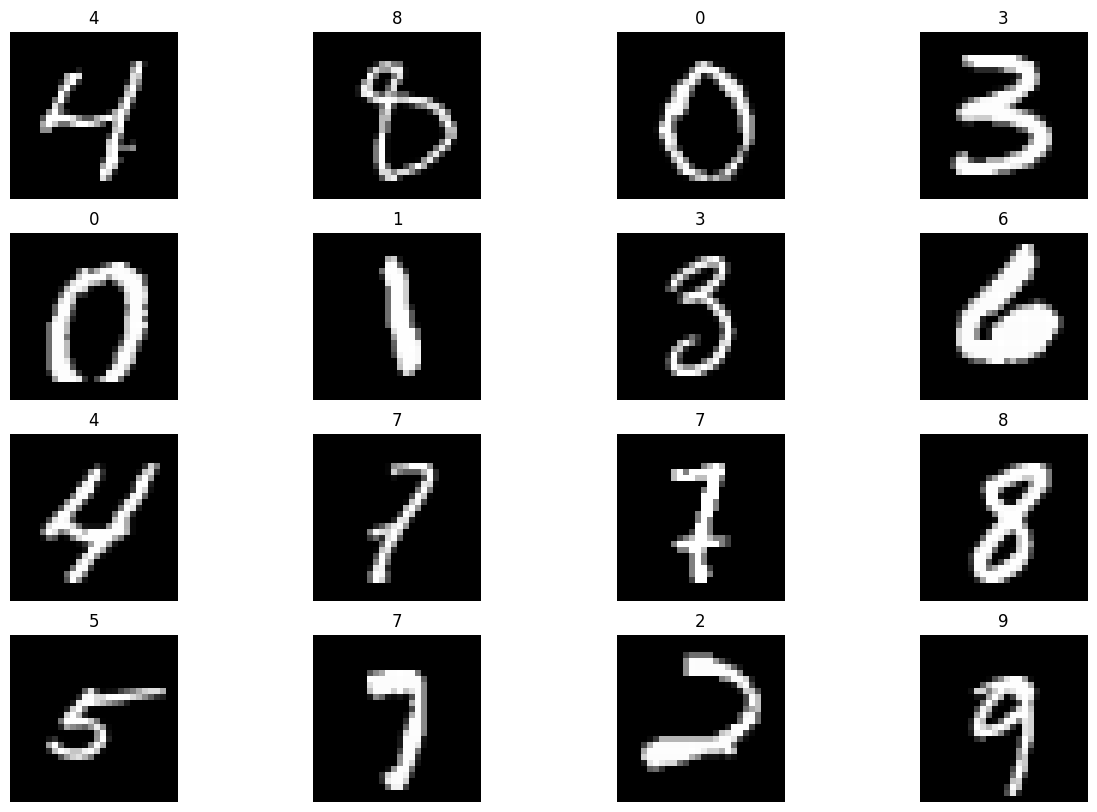

In [4]:
# displaying images
def displayImg(images, title):
  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(4, 4, i + 1)
    plt.title(title[i])
    plt.imshow(np.reshape(images[i], (28, 28)), cmap='gray')
    plt.axis('off')
  plt.show()


rand = np.random.randint(0, images.shape[0] - 16)
displayImg(images.iloc[rand:rand + 16].values, labels.iloc[rand:rand + 16].values)

# Preprocessing Data

In [5]:
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.20, random_state=0)

In [6]:
# reshaping data and scaling it from 0 to 1    
trainX = trainX.to_numpy().reshape(-1, 28, 28, 1) / 255
testX = testX.to_numpy().reshape(-1, 28, 28, 1) / 255

# Training Model

In [7]:
def createModel(learningRate, optimizer, activation, dropoutRate):
  model = Sequential([
    layers.Conv2D(32, (5, 5), activation=activation, input_shape=(28, 28, 1)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (5, 5), activation=activation),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(dropoutRate),

    layers.Dense(64, activation=activation),
    layers.BatchNormalization(),

    layers.Dense(32, activation=activation),
    layers.BatchNormalization(),

    layers.Dropout(dropoutRate),

    layers.Dense(10, activation='softmax')
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(learning_rate=learningRate)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(learning_rate=learningRate)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [8]:
# adding callback to avoid overfitting
earlyStopping = EarlyStopping(
  min_delta=0.005,
  patience=10,
  restore_best_weights=True
)

## Hyperparameter Tuning

**Note** : *This part of code is commented because it takes a lot of time to run.*

In [9]:
paramGrid = {
  'batch_size': [16, 32],
  'learningRate': [0.001, 0.01, 0.1],
  'optimizer': ['adam', 'sgd'],
  'dropoutRate': [0.1, 0.2],
  'activation': ['relu', 'tanh']
}

In [ ]:
#model = KerasClassifier(build_fn=createModel, verbose=0)

#gridSearch = GridSearchCV(model, paramGrid, cv=2, verbose=0).fit(trainX, trainY)

# finding the best parameters
#bestParams = gridSearch.best_params_
#print("Best Paramters :", bestParams)

# Best params : {'activation': 'relu', 'batch_size': 16, 'dropoutRate': 0.2, 'learningRate': 0.001, 'optimizer': 'adam'}

In [10]:
# fitting best parameters into model
bestModel = createModel(
  learningRate=0.001,
  optimizer='adam',
  activation='relu',
  dropoutRate=0.2
)

history = bestModel.fit(
  trainX, trainY,
  validation_data=(testX, testY),
  batch_size=16,
  epochs=20,
  callbacks=[earlyStopping]
)

Epoch 1/20
2100/2100 [==============================] - 16s 7ms/step - loss: 0.2631 - accuracy: 0.9241 - val_loss: 0.0667 - val_accuracy: 0.9805
Epoch 2/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0988 - accuracy: 0.9713 - val_loss: 0.0538 - val_accuracy: 0.9823
Epoch 3/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0707 - accuracy: 0.9784 - val_loss: 0.0402 - val_accuracy: 0.9877
Epoch 4/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0637 - accuracy: 0.9808 - val_loss: 0.0334 - val_accuracy: 0.9899
Epoch 5/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0511 - accuracy: 0.9842 - val_loss: 0.0311 - val_accuracy: 0.9898
Epoch 6/20
2100/2100 [==============================] - 14s 7ms/step - loss: 0.0439 - accuracy: 0.9872 - val_loss: 0.0341 - val_accuracy: 0.9894
Epoch 7/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 0.0380 - val_ac

In [11]:
historyDf = pd.DataFrame(history.history)

<Axes: >

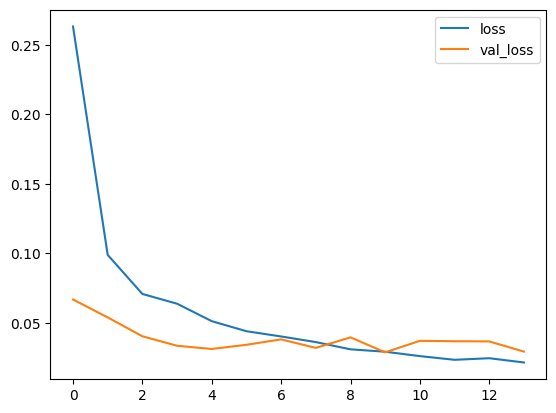

In [12]:
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

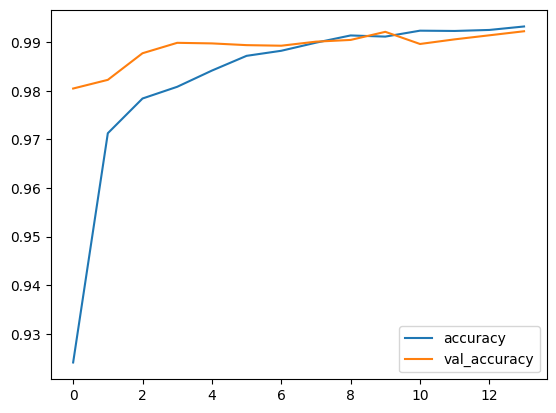

In [13]:
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

# Creating Submission

In [14]:
# reshaping test data
testData = testData.to_numpy().reshape(-1, 28, 28) / 255

In [15]:
# making predictions
pred = list(map(np.argmax, bestModel.predict(testData)))

875/875 [==============================] - 4s 4ms/step


Label predicted : 7 


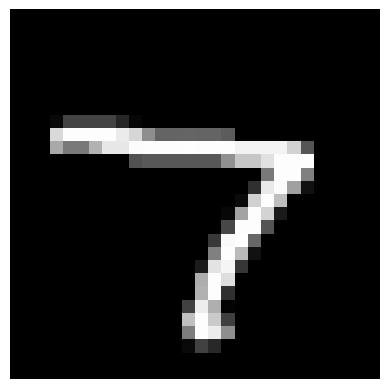

In [22]:
i = np.random.randint(0, 28000)
print('Label predicted :', pred[i], '\n')
plt.imshow(testData[i], cmap='gray')
plt.axis('off')
plt.show()

In [23]:
# creating submission csv
output = pd.DataFrame({'ImageId': range(1, 28001), 'Label': pred})
output.to_csv("Digit Recognizer.csv", index=False)

In [24]:
# Export to pickle file
import pickle

pickle.dump(bestModel, open('digit_recognizer.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........2

In [25]:
# Load model from pickle file
model = pickle.load(open('digit_recognizer.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-18 13:25:34         5332
metadata.json                                  2023-09-18 13:25:34           64
variables.h5                                   2023-09-18 13:25:34      1493016
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars

In [26]:
# Test model with a real drawing
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# Load image
img = Image.open('dataset/sample/img_4.png')

In [70]:
# Convert to grayscale
img = ImageOps.grayscale(img)

# Resize image
img = img.resize((28, 28))

# Convert to numpy array
img = np.array(img)

# Invert image
img = 255 - img

# Normalize image
img = img / 255

# Reshape image
img = img.reshape(-1, 28, 28, 1)

In [71]:
# Predict image
pred = model.predict(img)

1/1 [==============================] - 0s 16ms/step


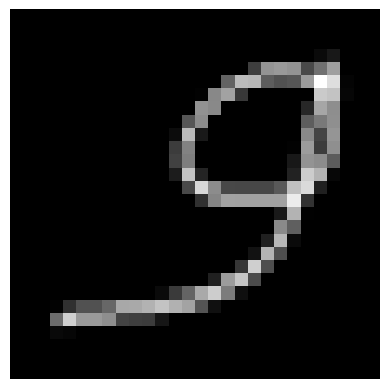

In [72]:
# Display image
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [73]:
# Display prediction
print('Label predicted :', np.argmax(pred))

# Display prediction probability
print('Prediction probability :', pred[0][np.argmax(pred)])

Label predicted : 4
Prediction probability : 0.345872


263/263 [==============================] - 1s 4ms/step


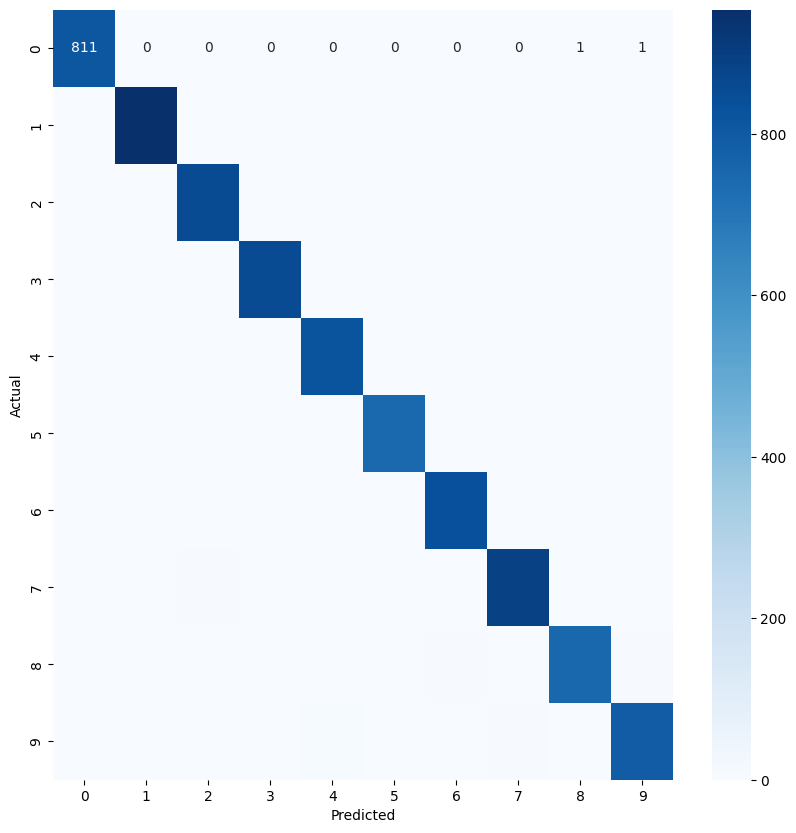

In [74]:
# Display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = list(map(np.argmax, model.predict(testX)))
cm = confusion_matrix(testY, pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [79]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


def create_lenet_model():
  model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model


lenet_model = create_lenet_model()


In [80]:
history = lenet_model.fit(
  trainX, trainY,
  validation_data=(testX, testY),
  batch_size=16,
  epochs=20,
  callbacks=[earlyStopping]
)

Epoch 1/20
2100/2100 [==============================] - 7s 3ms/step - loss: 0.2270 - accuracy: 0.9290 - val_loss: 0.0998 - val_accuracy: 0.9717
Epoch 2/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0786 - accuracy: 0.9746 - val_loss: 0.0877 - val_accuracy: 0.9732
Epoch 3/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0631 - val_accuracy: 0.9814
Epoch 4/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 0.0557 - val_accuracy: 0.9825
Epoch 5/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0551 - val_accuracy: 0.9829
Epoch 6/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0305 - accuracy: 0.9902 - val_loss: 0.0578 - val_accuracy: 0.9839
Epoch 7/20
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0258 - accuracy: 0.9913 - val_loss: 0.0627 - val_accuracy:

In [81]:
historyDf = pd.DataFrame(history.history)

<Axes: >

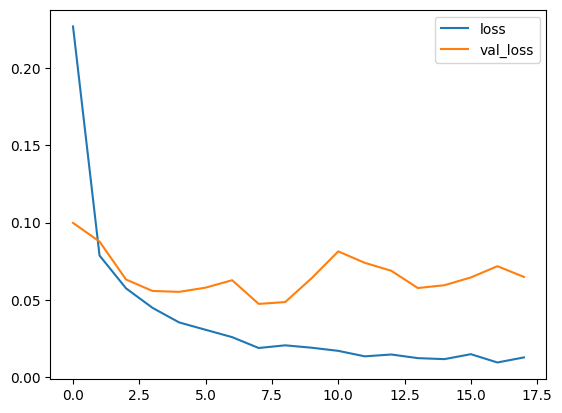

In [82]:
# Display loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

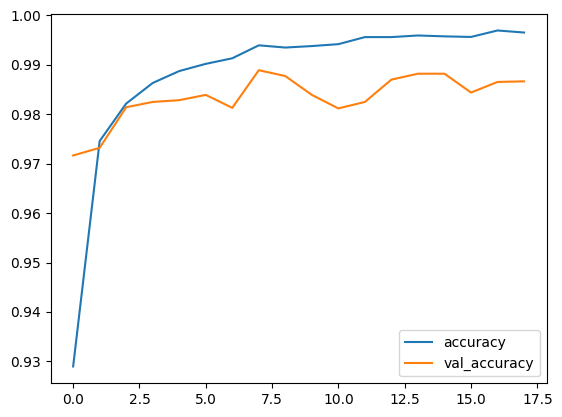

In [83]:
# Display accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [84]:
# Export to pickle file
import pickle

pickle.dump(lenet_model, open('lenet_model.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-18 13:45:17         3520
metad

In [85]:
# Load model from pickle file
model = pickle.load(open('lenet_model.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-18 13:45:16         3520
metadata.json                                  2023-09-18 13:45:16           64
variables.h5                                   2023-09-18 13:45:16       568952
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15


In [86]:
# Test model with a real drawing
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

In [105]:
# Load image
img = Image.open('dataset/sample/img.png')

In [106]:
# Convert to grayscale
img = ImageOps.grayscale(img)

# Resize image
img = img.resize((28, 28))

# Convert to numpy array
img = np.array(img)

# Invert image
img = 255 - img

# Normalize image
img = img / 255

# Reshape image
img = img.reshape(-1, 28, 28, 1)

In [107]:
# Predict image
pred = model.predict(img)

1/1 [==============================] - 0s 17ms/step


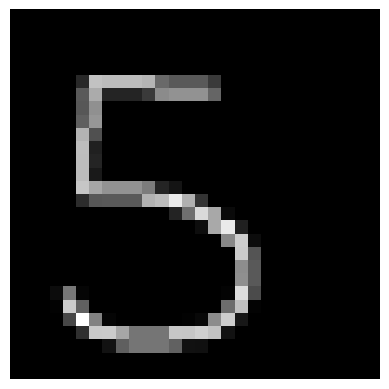

In [108]:
# Display image
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [109]:
# Display prediction
print('Label predicted :', np.argmax(pred))

# Display prediction probability
print('Prediction probability :', pred[0][np.argmax(pred)])

Label predicted : 3
Prediction probability : 0.8528201


263/263 [==============================] - 1s 2ms/step


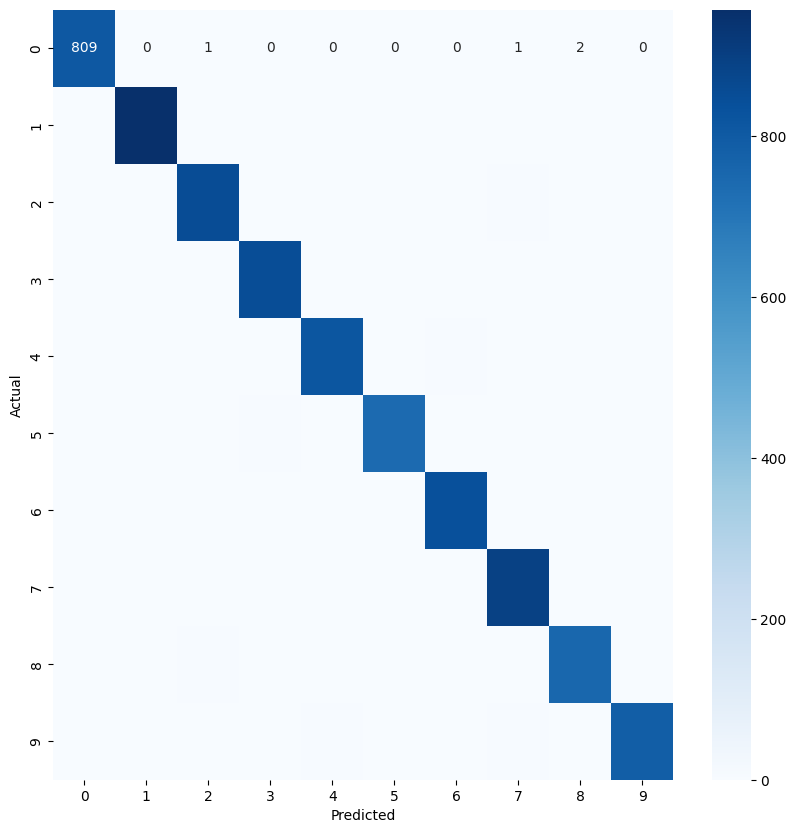

In [110]:
# Display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = list(map(np.argmax, model.predict(testX)))
cm = confusion_matrix(testY, pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()